# IRIS Data Visualization and Classification
This notebook uses python to visualize and classify the IRIS dataset. Dataset can be obtained from kaggle webiste: https://www.kaggle.com/uciml/iris

In [57]:
# import numpy and pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./input"))

['Iris.csv']


### Read the IRIS dataset and display first few rows

In [58]:
iris_dataset = pd.read_csv('./input/Iris.csv')
iris_dataset.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


### Separate the feature vector and labels

In [59]:
iris_features_df = iris_dataset[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
iris_labels_df = iris_dataset[["Species"]]
iris_labels_df.head()

,Species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


### Print the unique labels

In [60]:
iris_labels_df["Species"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

### Finding the correlation between the columns

In [61]:
iris_df_corr = iris_features_df.corr(method="pearson")
iris_df_corr

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


### Use correlation matrix to generate the graph using networkx

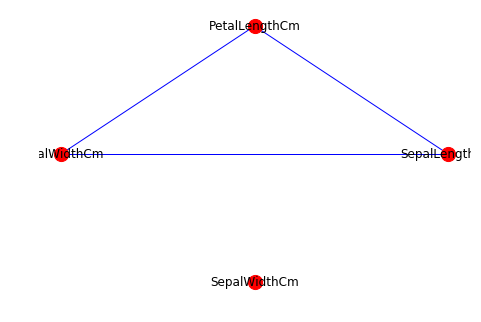

In [62]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
iris_df_corr_df = iris_df_corr.stack().reset_index()
iris_df_corr_df.columns = ["Dim1","Dim2", "Corr"]
iris_df_corr_df

network_df=iris_df_corr_df[iris_df_corr_df['Corr'] >= 0.8]
graph = nx.from_pandas_edgelist(network_df, 'Dim1', 'Dim2', edge_attr=True)
nx.draw_circular(graph, with_labels=True, node_color='red', node_size=200, edge_color='blue', linewidths=1, font_size=12)

### Split the dataset into training ans testing set

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_features_df, iris_labels_df, test_size=.25)

X_train = X_train.reset_index().drop(['index'],axis=1)
X_test  = X_test.reset_index().drop(['index'],axis=1)
y_train = y_train.reset_index().drop(['index'],axis=1)
y_test  = y_test.reset_index().drop(['index'],axis=1)

# Print the size of training and test data
print(f"Train Data Size = {X_train.shape[0]}\nTest Data Size = {X_test.shape[0]}\n ")

# X_train.head()
# y_train.head()

Train Data Size = 112
Test Data Size = 38
 


### Scale the features using sklearn

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

pd.DataFrame(X_train_scaled, columns=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]).head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.315055,-0.356883,-0.092274,0.131898
1,-0.315055,-0.132328,0.427349,0.400491
2,-1.178703,-1.255106,0.427349,0.669084
3,0.918727,-0.356883,0.485085,0.131898
4,0.795349,-0.581439,0.485085,0.400491


### Use PCA to reduce the dimensionality of data from 4d to 2d

In [65]:
from sklearn.decomposition import PCA as sklearnPCA

pca = sklearnPCA(n_components=2) #2-dimensional PCA
X_train_scaled_2D = pd.DataFrame(pca.fit_transform(X_train_scaled))
X_test_scaled_2D = pd.DataFrame(pca.fit_transform(X_test_scaled))

X_train_scaled_2D = pd.DataFrame(X_train_scaled_2D)
X_test_scaled_2D = pd.DataFrame(X_test_scaled_2D)

### Use <em>bokeh<em> to plot the data

In [66]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show
from bokeh.palettes import inferno as palette
import itertools
output_notebook()

# Combine the data for plotting
data_combine = pd.concat([X_train_scaled_2D, y_train], axis=1)
# data_combine[1]



Loading BokehJS ...

### Plot the dimensions using Bokeh

In [67]:
plot = figure(x_axis_label='PCA Dim 1', y_axis_label='PCA Dim 2', title='IRIS Dataset in 2D')
unique_species = list(data_combine['Species'].unique())

# colors = itertools.cycle(palette(len(unique_species)))
colors = ['Red', 'Green', 'Blue']


for species_name, color in zip(unique_species, colors):
        data = data_combine[data_combine['Species'] == species_name]
        plot.circle(x=data[0], y=data[1], legend=species_name , color=color, line_width=2)
show(plot, notebook_handle=True)

### Use the reduced dimensions for classification [Using LinearSVC]

In [68]:
# X_train_scaled_2D, y_train
# X_test_scaled_2D, y_test

from sklearn.svm import LinearSVC
clf = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)
clf.fit(X_train_scaled, y_train)
print(f'Coefficients = {clf.coef_}')
print(f'Intercept = {clf.intercept_}')
predicted = clf.predict(X_test_scaled)
# predicted

Coefficients = [[-0.14324335  0.41177669 -0.70307539 -0.69385528]
 [ 0.11827081 -0.52802696  0.51476235 -0.61773149]
 [-0.34397114 -0.21356823  1.70244712  1.46819329]]
Intercept = [-0.76253351 -0.3026407  -1.95093668]


/Users/rishabhzn200/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Display the accuracy

In [69]:
y_predicted = np.array(list(predicted))
y_actual = np.array(y_test['Species'].values.tolist())

count = 0
for p, a in zip(y_predicted, y_actual):
    if p == a:
        count += 1
accuracy = count*100/len(y_predicted)
accuracy

97.36842105263158